<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/8_8_Designing_Convulation_Network_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8.8 : Designing Convulation Network Architectures

In [ ]:
!pip install matplotlib_inline
!pip install --upgrade d2l==1.0.0a0

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
import torch.nn.functional as F

In [5]:
class ResNeXtBlock(nn.Module):

  def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
    # groups : width of each group
    # bot_mul : is the ratio, less than or equal to 1 : so that we can decrease the computational cost
    super().__init__()
    bot_channels = int(round(num_channels * bot_mul))
    self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1)
    self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3, padding=1, stride=strides, groups = bot_channels // groups)
    self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
    self.bn3 = nn.LazyBatchNorm2d()

    if use_1x1conv:
      self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
      self.bn4 = nn.LazyBatchNorm2d()
    else:
      self.conv4 = None
    
  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = F.relu(self.bn2(self.conv2(Y)))
    Y = self.bn3(self.conv3(Y))
    if self.conv4 is not None:
      X = self.bn4(self.conv4(X))
    return F.relu(Y+X)

In [6]:
class AnyNet(d2l.Classifier):

  def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))

    for i, s in enumerate(arch):
      self.net.add_module(f"stage{i+1}", self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), 
        nn.LazyLinear(num_classes))
    )

    self.net.apply(d2l.init_cnn)

  def stem(self, num_channels):
    return nn.Sequential(
        nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1), nn.LazyBatchNorm2d(), nn.ReLU()
    )

  def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
      if (i == 0):
        blk.append(ResNeXtBlock(num_channels, groups, bot_mul, use_1x1conv=True, strides=2))
      else:
        blk.append(ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

  def forward(self, X):
    return self.net(X)

In [7]:
a, b = (4, 32), (6, 80)

In [8]:
a

(4, 32)

In [7]:
class RegNet32(AnyNet):

  def __init__(self, lr=0.1, num_classes=10):
    stem_channels, groups, bot_mul = 32, 16, 1
    depths, channels = (4, 6), (32, 80)
    arch = ((depths[0], channels[0], groups, bot_mul),
            (depths[1], channels[1], groups, bot_mul))
    super().__init__(arch, stem_channels, lr, num_classes)

In [8]:
RegNet32().layer_summary((1, 1, 96, 96))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


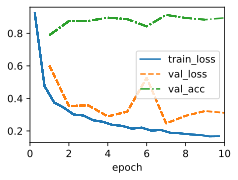

In [9]:
model = RegNet32(lr=0.05)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Ex 8.8:

### Q1 : 

In [18]:
class RegNet_4(AnyNet):
  
  def __init__(self, lr=0.1, num_classes=10):
    stem_channels, groups, bot_mul = 32, 16, 1
    depths, channels = (4, 6, 8, 10), (64, 128, 256, 512)
    arch = ((depths[0], channels[0], groups, bot_mul),
            (depths[1], channels[1], groups, bot_mul),
            (depths[2], channels[2], groups, bot_mul),
            (depths[3], channels[3], groups, bot_mul))
    super().__init__(arch, stem_channels, lr, num_classes)

<>:8: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:8: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<ipython-input-18-f8d8047ae76c>:8: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (depths[2], channels[2], groups, bot_mul)


### Q2 : 

using simple Residual blocks instead of ResNeXt block

In [15]:
class Residual(nn.Module):

  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)

    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
      self.bn3 = nn.LazyBatchNorm2d()
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))

    if self.conv3 is not None:
      X = self.bn3(self.conv3(X))
    return F.relu(X + Y)